# Task B - Step 1: Transformer-Based Sentiment Analysis


- **OLD**: Used VADER (lexicon-based sentiment analyzer)
- **NEW**: Using Transformer model as per project requirements
- **Why**: Transformers understand context better than rule-based approaches

#### Installing Required Packages

In [5]:
# Install transformers and torch if not already installed
!pip install transformers torch pandas

In [6]:
## Import Libraries
import pandas as pd
import torch
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available (makes processing faster)
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

Using device: CPU


#### Step 1: Load Reddit Data
Load the scraped Reddit posts from our dataset

In [8]:
# Load CSV file with scraped Reddit posts
df = pd.read_csv("reddit_llms_with_image_embeddings.csv")

print(f"Loaded {len(df)} posts from {df['subreddit'].nunique()} subreddits")
print(f"Subreddits: {df['subreddit'].unique().tolist()}")

# Show first few rows to verify data
df.head()

Loaded 2440 posts from 5 subreddits
Subreddits: ['ChatGPT', 'ClaudeAI', 'GeminiAI', 'GrokAI', 'DeepSeek']


,id,title,selftext,score,num_comments,url,created_utc,subreddit,has_image,embedding_text,embedding_image,embedding_combined
0,1ogadtk,Mock Test Answers Always B.,I have been requesting sample test questions t...,1,1,https://www.reddit.com/r/ChatGPT/comments/1oga...,1761448982,ChatGPT,N,"[-0.03230305761098862, -0.017079366371035576, ...",NaN,"[-0.03230305761098862, -0.017079366371035576, ..."
1,1ogaaic,anyone else noticing a dark side of themselves...,i didn't know i could be so mean until recentl...,1,4,https://i.redd.it/4exxtomyidxf1.jpeg,1761448677,ChatGPT,Y,"[-0.029359212145209312, -0.10590557008981705, ...","[0.19259345531463623, 0.34009629487991333, 0.0...","[0.08161712158471346, 0.11709536239504814, 0.0..."
2,1oga6th,workshopping your health diagnosis should not ...,NaN,1,1,https://www.reddit.com/r/ChatGPT/comments/1oga...,1761448320,ChatGPT,N,"[0.014168061316013336, 0.029538938775658607, -...",NaN,"[0.014168061316013336, 0.029538938775658607, -..."
3,1og9qdp,Please Help?,I’m 7 messages in and already it’s given me a ...,1,7,https://i.redd.it/1jieoj0rddxf1.jpeg,1761446820,ChatGPT,Y,"[0.017262034118175507, -0.0008401406230404973,...","[-0.5454086661338806, 0.0916564017534256, -0.3...","[-0.26407331600785255, 0.04540813056519255, -0..."
4,1og9o5h,OpenAI employee talks about how the company ac...,NaN,3,1,https://i.redd.it/faapwme4ddxf1.jpeg,1761446626,ChatGPT,Y,"[0.012571862898766994, 0.004577984102070332, -...","[-0.14578351378440857, 0.06404184550046921, 0....","[-0.06660582544282079, 0.03430991480126977, 0...."


## Step 2: Preparing the Text Data
Combine title and selftext for sentiment analysis

In [9]:
# Combine title and selftext into single field
# This gives us the full context of each post
df['text'] = (df['title'].fillna('') + ' ' + df['selftext'].fillna('')).str.strip()

# Remove any empty posts (shouldn't be any but good practice)
df = df[df['text'].str.len() > 0].reset_index(drop=True)

print(f"Created combined text field for {len(df)} posts")
print(f"Average text length: {df['text'].str.len().mean():.0f} characters")
print(f"Max text length: {df['text'].str.len().max():.0f} characters")

Created combined text field for 2440 posts
Average text length: 710 characters
Max text length: 30745 characters


## Step 3: Initialize Transformer Model

Using `cardiffnlp/twitter-roberta-base-sentiment-latest` which:
- Is a Transformer model (RoBERTa architecture)
- Trained on social media text (perfect for Reddit)
- Understands context and sarcasm better than VADER
- Outputs: POSITIVE, NEUTRAL, NEGATIVE with confidence scores

In [12]:
# Load the Transformer sentiment model
# FIXED: Added framework="pt" to force PyTorch and avoid TensorFlow/Keras issues
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_name,
    framework="pt",       # Force PyTorch (avoids TensorFlow/Keras error)
    device=device,        # Use GPU if available
    max_length=512,       # Max tokens the model can handle
    truncation=True       # Truncate if text is too long
)

print(f"Loaded model: {model_name}")
print(f"Model type: RoBERTa (Transformer)")
print(f"Trained on: Social media text")
print(f"Framework: PyTorch")

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Loaded model: cardiffnlp/twitter-roberta-base-sentiment-latest
Model type: RoBERTa (Transformer)
Trained on: Social media text
Framework: PyTorch


## Step 4: Running Sentiment Analysis
Process all posts through the Transformer model to get sentiment labels.

In [14]:
# Process posts in batches for efficiency
batch_size = 16  # Process 16 posts at a time

sentiments = []  # Store sentiment labels
scores = []      # Store confidence scores

print("Running sentiment analysis...")
print(f"Processing {len(df)} posts in batches of {batch_size}...\n")

# Process in batches
for i in range(0, len(df), batch_size):
    # Get batch of texts
    batch_texts = df['text'].iloc[i:i+batch_size].tolist()
    
    # Truncate very long texts (model has 512 token limit)
    batch_texts = [text[:512] for text in batch_texts]
    
    # Run sentiment analysis
    results = sentiment_analyzer(batch_texts)
    
    # Extract labels and scores
    for result in results:
        sentiments.append(result['label'])
        scores.append(result['score'])
    
    # Show progress every 10 batches
    if (i // batch_size) % 10 == 0:
        print(f"Processed {min(i + batch_size, len(df))}/{len(df)} posts...")

print(f"\n Completed sentiment analysis for all {len(df)} posts")

Running sentiment analysis...
Processing 2440 posts in batches of 16...

Processed 16/2440 posts...
Processed 176/2440 posts...
Processed 336/2440 posts...
Processed 496/2440 posts...
Processed 656/2440 posts...
Processed 816/2440 posts...
Processed 976/2440 posts...
Processed 1136/2440 posts...
Processed 1296/2440 posts...
Processed 1456/2440 posts...
Processed 1616/2440 posts...
Processed 1776/2440 posts...
Processed 1936/2440 posts...
Processed 2096/2440 posts...
Processed 2256/2440 posts...
Processed 2416/2440 posts...

 Completed sentiment analysis for all 2440 posts


## Step 5: Add Results to DataFrame and Save

In [16]:
# Add new columns with sentiment results
df['sentiment_label'] = sentiments
df['sentiment_score'] = scores

# Standardize labels to lowercase for consistency
df['sentiment_label'] = df['sentiment_label'].str.lower()

# Save enriched dataset
output_path = "reddit_llms_with_sentiment.csv"
df.to_csv(output_path, index=False)

print(f"Saved results to: {output_path}")
print(f"New columns added: 'text', 'sentiment_label', 'sentiment_score'")
print(f"\nDataFrame shape: {df.shape}")
df[['title', 'sentiment_label', 'sentiment_score']].head(10)

Saved results to: reddit_llms_with_sentiment.csv
New columns added: 'text', 'sentiment_label', 'sentiment_score'

DataFrame shape: (2440, 15)


,title,sentiment_label,sentiment_score
0,Mock Test Answers Always B.,neutral,0.591918
1,anyone else noticing a dark side of themselves...,negative,0.908086
2,workshopping your health diagnosis should not ...,neutral,0.625602
3,Please Help?,negative,0.667502
4,OpenAI employee talks about how the company ac...,neutral,0.899369
5,AuraOS Version 2.3 -- w/ User Instructions,neutral,0.860516
6,Can't edit??,negative,0.912077
7,I built a “dialectical” training harness that ...,neutral,0.541436
8,?What policy didn't I follow?,negative,0.569632
9,Billions into the pipeline yet can't even form...,negative,0.754768


#### Step 6: Analyze Results

Looking at the sentiment distribution across our dataset

OVERALL SENTIMENT DISTRIBUTION
Positive  :  414 posts (16.97%)
Neutral   : 1265 posts (51.84%)
Negative  :  761 posts (31.19%)


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment_label'>

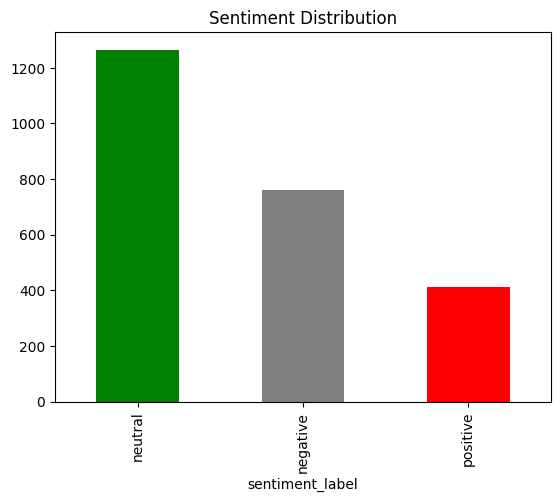

In [17]:
# Overall sentiment distribution
print("="*70)
print("OVERALL SENTIMENT DISTRIBUTION")
print("="*70)

sentiment_counts = df['sentiment_label'].value_counts()
sentiment_pct = (sentiment_counts / len(df) * 100).round(2)

for label in ['positive', 'neutral', 'negative']:
    if label in sentiment_counts.index:
        count = sentiment_counts[label]
        pct = sentiment_pct[label]
        print(f"{label.capitalize():10s}: {count:4d} posts ({pct:5.2f}%)")

# Visualize
sentiment_counts.plot(kind='bar', title='Sentiment Distribution', color=['green', 'gray', 'red'])